# Template for multi-pitch detection TP

*(reference: Klapuri) but with pitch detection with spectral sum

*From G. Richard (with help from P. Vernhet), MAJ:2019*

**python version : 3.6**

In [1]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil

Functions

In [2]:
def load_music(file):
    return wave.open(file, 'rb')


def play_music(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_music(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()
    

def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return p, x_


def f2idx(F, df):
    """
    Convert frequency to corresponding index in "frequencies" array
    """
    return ceil(F/df)

## 0 - Reading and playing .wav file

Choose the name of music for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
current_path = os.getcwd()
data_path = os.path.join(current_path, 'sons_multipitch')
filename = 'A4_piano.wav'
music = os.path.join(data_path, filename) 

### **Using wave**

In [4]:
wavefile = load_music(music)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=32000, nframes=31994, comptype='NONE', compname='not compressed')


In [5]:
play = True
if play :
    play_music(music) 

In [6]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [7]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

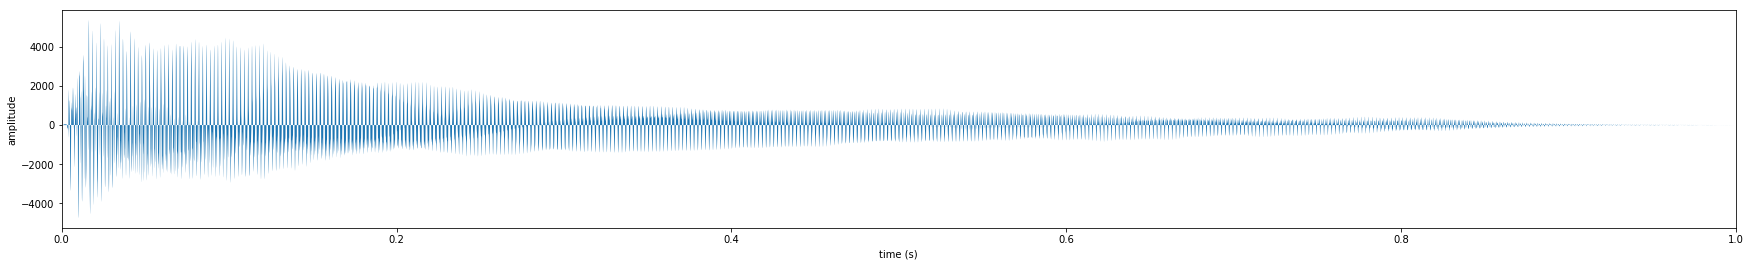

In [8]:
plot_sound(x, times)

## I - Window and Fast Fourier Transform


**1. Window size :** A Hamming window is used, its length covering $700$ ms of the entire signal 

**2. Offset :** The offset is chosen to be about $100$ ms, 

**3. Spectral precision after the FFT :** The frequency precision is given by $dF_{\text{min}}=\frac{F_{s}}{Nfft}$, where $Nfft$ is the size of the FFT window. 


In [9]:
N=ceil(0.7*Fs)       # Window size of analysed signal (only one window of signal is analysed)
dF_min=Fs/N   # Minimal frequency resolution
print('The minimal frequency resolution is of {:.2f} Hz'.format(dF_min))

The minimal frequency resolution is of 1.43 Hz


In [10]:
w=np.hamming(N)  # Window
width = 4*dF_min # largeur du pic spectral (en Hz) 4*dF_min
eps=float(1e-20)   #precision

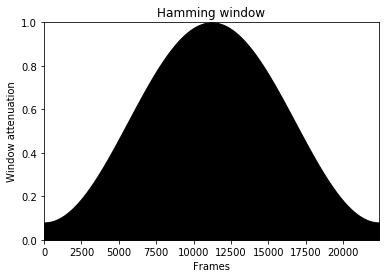

In [11]:
plt.fill_between(np.arange(len(w)), w, color='k')
plt.title('Hamming window')
plt.xlabel('Frames')
plt.ylabel('Window attenuation')
plt.xlim(0, len(w))
plt.ylim(0, 1)
plt.show()

### Discarding the attack of the sound

In [15]:
offset=ceil(0.1*Fs)
xw=x[offset:offset+N]*w    # xw is the analysed signal frame
n_xw = xw.size

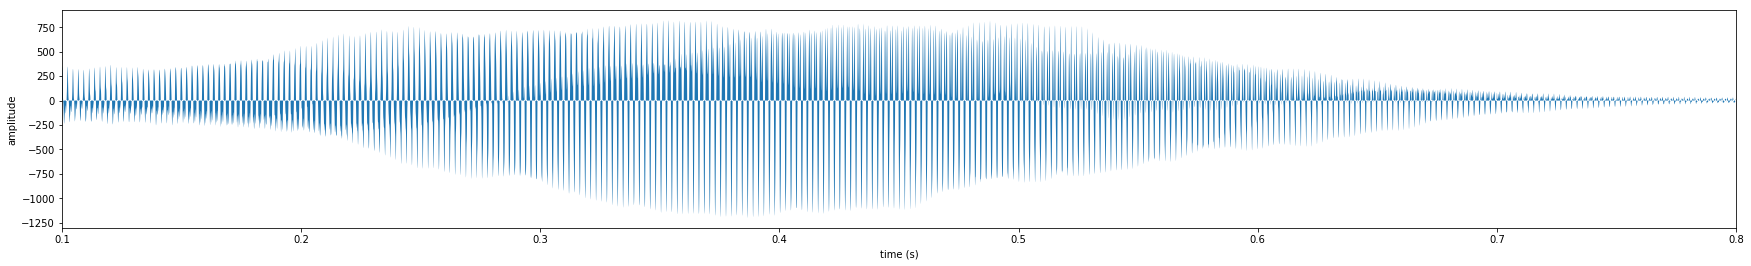

In [16]:
plot_sound(xw, times[offset:offset+N])

This is the temporal visualization of the sound we will be working on.

### Processing for efficient FFT (*by truncating to powers of 2*)

In [17]:
#Minimal number of data points to satisfy the minimal frequency resolution
Nfft_min=Fs/dF_min

#compute the smallest power of two that satisfies the minimal frequency resolution for FFT
p, Nfft = nextpow2(Nfft_min)
x_fft = np.fft.fft(xw, n=Nfft) #calcul FFT
x_fft /= np.max(np.abs(x_fft))+eps # Normalization

df=Fs/Nfft # frequency virtual resolution of FFT 
print('Frequency virtual resolution of FFT {:.2} Hz'.format(df))

Frequency virtual resolution of FFT 0.98 Hz


In [18]:
frequencies = np.arange(Nfft)*df  # equivalent to np.fft.fftfreq(n=Nfft, d=timestep)
X_fft = np.abs(x_fft) # absolute value of FFT (phase doesn't play a role)

Plot FFT spectrum

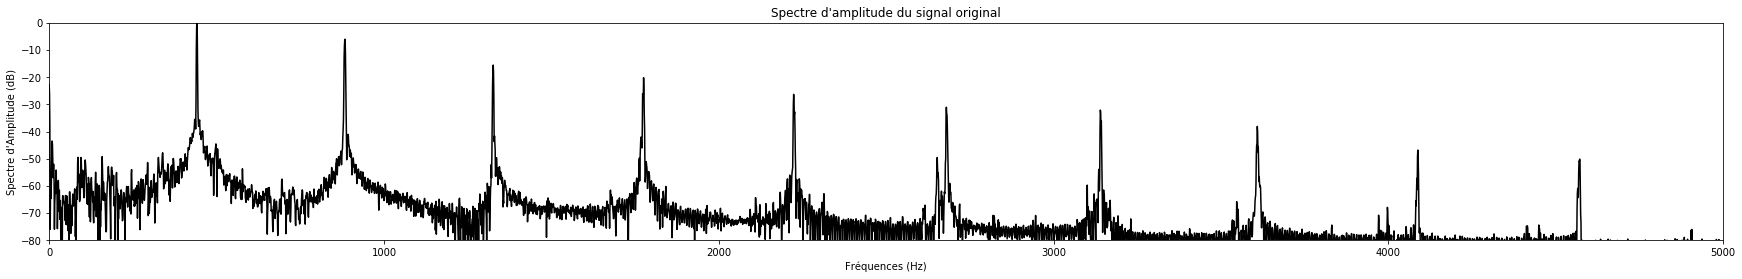

In [19]:
plt.figure(figsize=(30, 4))
plt.plot(frequencies[:int(Nfft/2)], 20*np.log10(X_fft[:int(Nfft/2)]), color='k')
plt.xlim(0, 5000)
plt.ylim(-80, 0)
plt.xlabel('Fréquences (Hz)')
plt.ylabel('Spectre d\'Amplitude (dB)')
plt.title('Spectre d\'amplitude du signal original')
plt.show()

For **A4_piano.wav**, we clearly see the harmonic around $\sim 440$ Hz and partials (multiples of the fundamental frequency peak).

## II - Fundamental frequency estimation by spectral product/sum method

The different steps include :

#loop on the number of pitches
    - example criterion could use an energy ratio "while criterion > seuil_F0"
    
  #Detection of main F0
  
        -Compute spectral sum
        -locate maximum
        -store value of estimated F0

  #Subtraction of main note (Main F0 with its harmonics)
        
        -localisation of harmonics around theoretical values (with or without inharmonicy coefficient) 
        - beta: harmonicity coefficient ;  alpha: coefficient of tolerance
                
        - Harmonic suppression (wideness of an harmonic to be suppressed depends on the main lob of the TF of the analysis window); suppression of harmonics is done on abs(Xk) on forcing all values of a harmonic peak to the minimum value of the peak (e.g. the level of noise).
         
#end of loop

In [22]:
Fmin=100             # Minimal F0 frequency that can be detected
Fmax=900             # Maximal F0 frequency that can be detected
H=4                  # H = nombre de versions compressées
Rmax = ceil((Nfft-1)/(2*H)) # fréquence maximale

In [23]:
Nmin = f2idx(Fmin,df)-1
Nmax = f2idx(Fmax,df)
assert Nmax <= Rmax and Nmin >= 0

Functions sum and product

In [12]:
def spectral_prod(x, R, H):
    """
    Spectral Product
    """
    TO BE COMPLETED
    
    return prod


def spectral_sum(x, R, H):
    """
    Spectral sum
    """
    TO BE COMPLETED
    return summ


def spectral_method(x, R, H, method='product'):
    """
    Factorization of previous methods
    """
    assert method in ['sum', 'product']
    if method == 'sum':
        return spectral_sum(x, R, H)
    else:
        return spectral_prod(x, R, H)

SyntaxError: invalid syntax (<ipython-input-12-61815ac0684d>, line 5)

Maximum Search

In [13]:
method = 'product'
P = spectral_method(X_fft, Rmax, H, method)

NameError: name 'spectral_method' is not defined